# Image Noise Analysis and Histogram Plotting

This Jupyter Notebook performs various image processing tasks, including loading images, adding noise, and plotting histograms to analyze the effects of different types of noise on images. The notebook is structured as follows:

1. **Importing Libraries**:
    - The necessary libraries for image processing and plotting are imported, including `cv2`, `os`, `numpy`, `skimage`, and `matplotlib`.

2. **Plotting Histograms**:
    - A function `plot_histogram` is defined to plot histograms of image pixel intensities.
    - Images are loaded from a specified folder, and histograms are plotted for a grid of images.

3. **Adding Noise and Calculating Divergences**:
    - A single image is selected, and different types of noise (Gaussian, Poisson, Speckle, and Blur) are added to it.
    - Histograms of the noisy images are calculated, and the Kullback-Leibler (KL) and Jensen-Shannon (JS) divergences between the original and noisy histograms are computed.
    - The original and noisy images, along with their histograms and divergence values, are plotted for comparison.

4. **Variables**:
    - Various variables are used throughout the notebook, including:
      - `NUM_IMAGES`: Number of images to display.
      - `ax`, `axes`: Matplotlib axes for plotting.
      - `bins`: Bins used for histogram calculation.
      - `fig`: Matplotlib figure for plotting.
      - `image`, `image_file`, `image_files`: Image data and file paths.
      - `kl_div`, `js_div`: Divergence values.
      - `noise_args`, `noise_mode`, `noise_modes`: Noise parameters and modes.
      - `noisy_images`, `original_hist`, `single_image`: Image data for noisy and original images.

This notebook provides a comprehensive analysis of how different types of noise affect image histograms and allows for visual comparison of the original and noisy images.

In [2]:
# Import necessary libraries
import cv2
import os
import numpy as np
from skimage import io, img_as_float
from skimage.restoration import estimate_sigma, denoise_wavelet
from skimage.filters import laplace
import matplotlib.pyplot as plt
# import torch  #uncmment if you want to use pytorch
# import torchvision
# print(torch.__version__)
# print(torchvision.__version__)

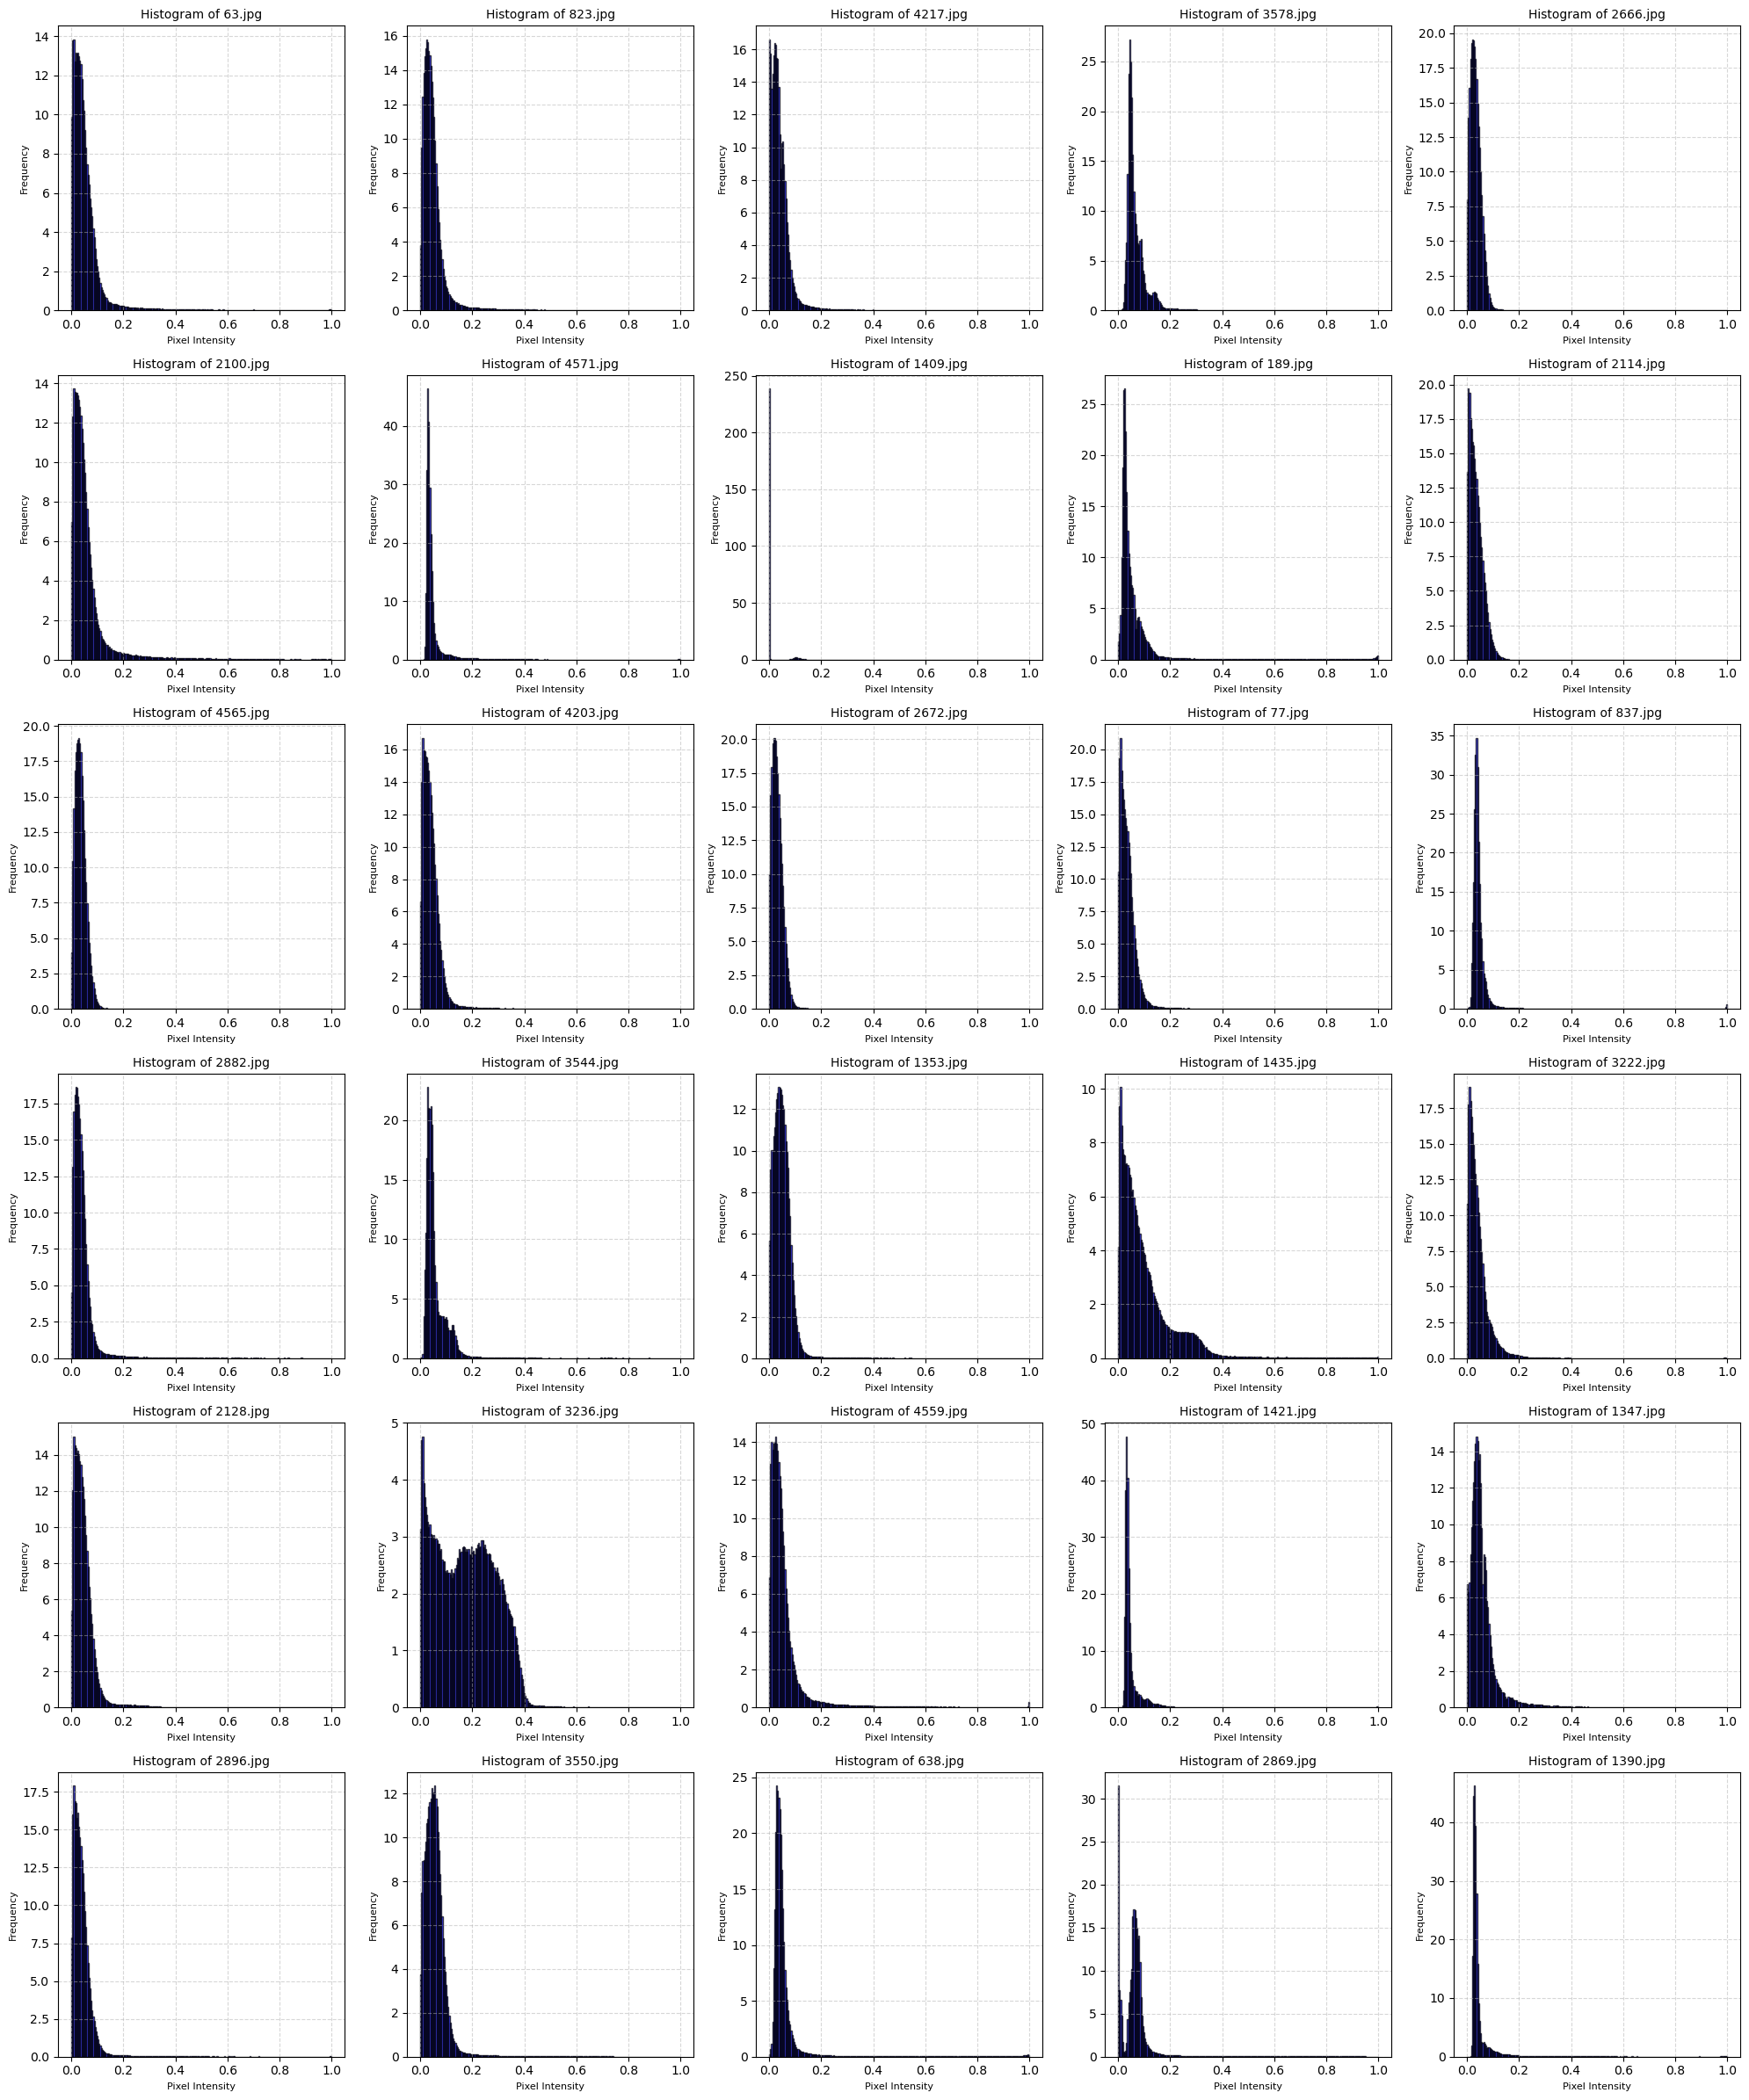

In [4]:
# Function to plot histograms
def plot_histogram(image, title):
    plt.figure(figsize=(10, 6))
    plt.hist(image.ravel(), bins=256, range=(0, 1), density=True, color='blue', alpha=0.7, edgecolor='black')
    plt.title(title, fontsize=15)
    plt.xlabel('Pixel Intensity', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Load images from the folder
image_folder = './DeepSpaceYoloDataset/images'
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.jpg')]

# Number of images to display
NUM_IMAGES = 30

# Plot histograms for a grid of images
fig, axes = plt.subplots(NUM_IMAGES // 5, 5, figsize=(20, 4 * (NUM_IMAGES // 5)))
axes = axes.flatten()

for ax, image_file in zip(axes, image_files[:NUM_IMAGES]):
    image = img_as_float(io.imread(image_file, as_gray=True))
    ax.hist(image.ravel(), bins=256, range=(0, 1), density=True, color='blue', alpha=0.7, edgecolor='black')
    ax.set_title(f'Histogram of {os.path.basename(image_file)}', fontsize=10)
    ax.set_xlabel('Pixel Intensity', fontsize=8)
    ax.set_ylabel('Frequency', fontsize=8)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


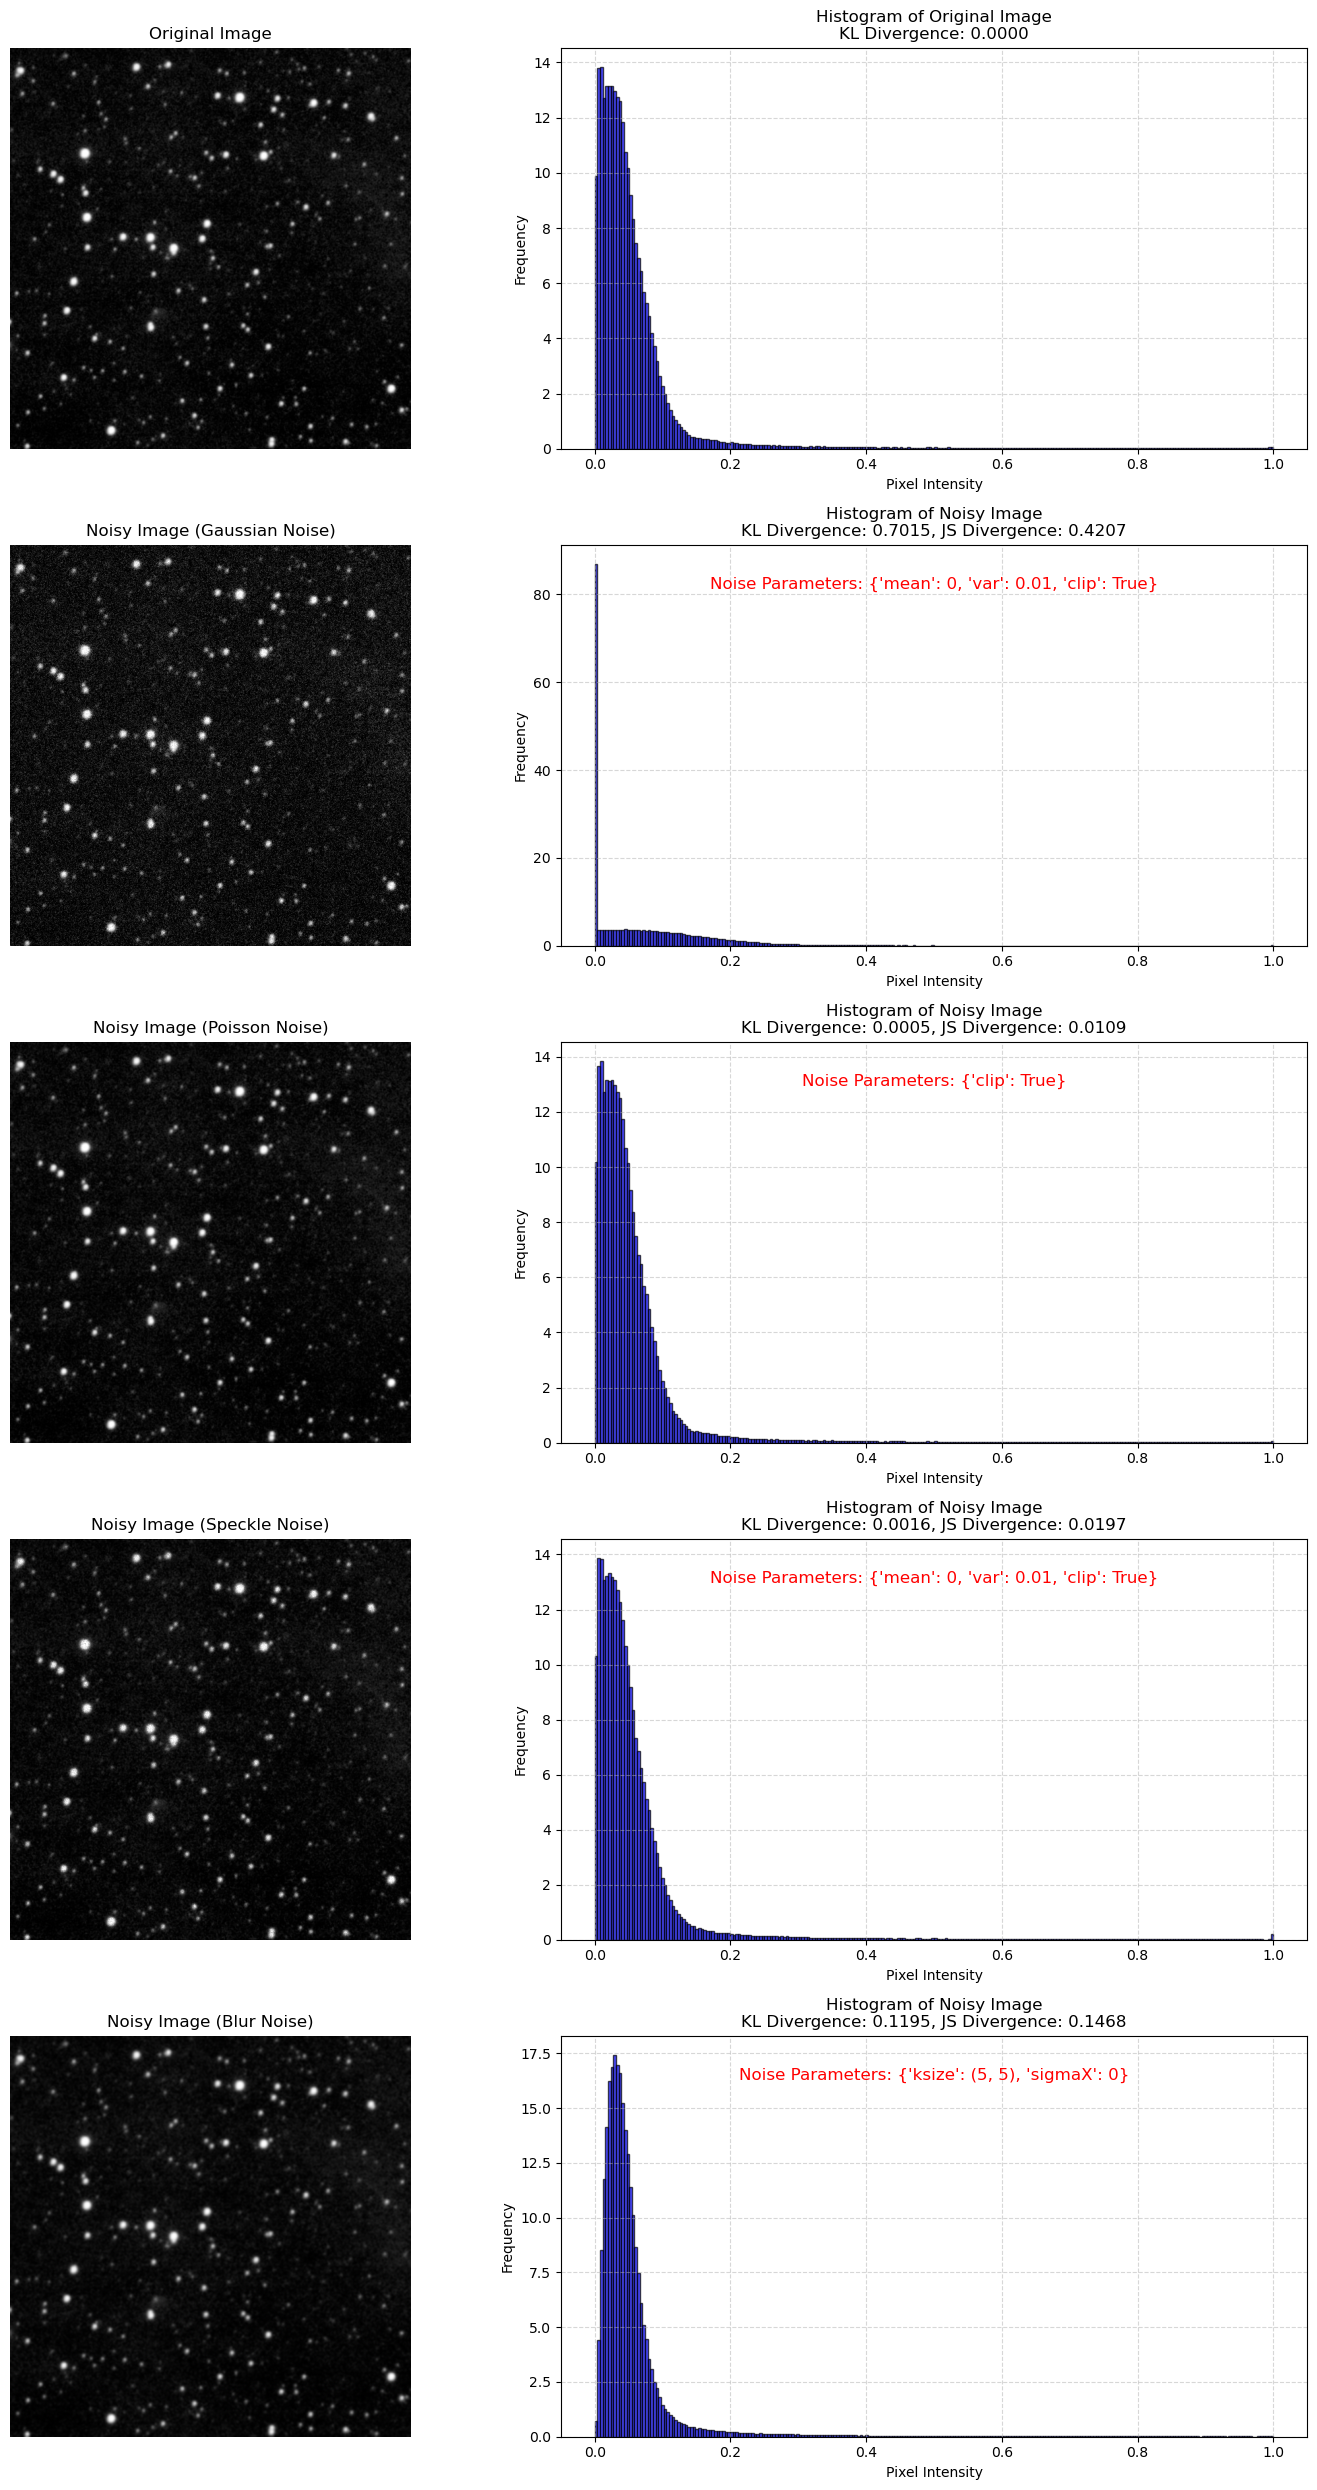

In [5]:
from skimage.util import random_noise
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

# Select a single image file
single_image_file = image_files[0]
single_image = img_as_float(io.imread(single_image_file, as_gray=True))

# Define list of noise modes
noise_args = {
    'gaussian': {'mean': 0, 'var': 0.01, 'clip': True},
    'poisson': {'clip': True},
    'speckle': {'mean': 0, 'var': 0.01, 'clip': True},
    'blur': {'ksize': (5, 5), 'sigmaX': 0}
}

noise_modes = ['gaussian', 'poisson', 'speckle', 'blur']

# Initialize lists to store results
noisy_images = []
kl_divs = []
js_divs = []

# Calculate histogram for the original image
original_hist, bins = np.histogram(single_image.ravel(), bins=256, range=(0, 1), density=True)

# Loop over each noise mode
for noise_mode in noise_modes:
    # Add noise to the image using random_noise function
    if noise_mode == 'blur':
        noisy_image = cv2.GaussianBlur(single_image, (5, 5), 0)
    else:
        noisy_image = random_noise(single_image, mode=noise_mode, **noise_args[noise_mode])
    
    # Calculate histograms
    noisy_hist, _ = np.histogram(noisy_image.ravel(), bins=256, range=(0, 1), density=True)
    
    # Calculate divergences
    kl_div = entropy(original_hist, noisy_hist)
    js_div = jensenshannon(original_hist, noisy_hist)
    
    # Store results
    noisy_images.append(noisy_image)
    kl_divs.append(kl_div)
    js_divs.append(js_div)

# Plot the original image and its histogram
fig, axes = plt.subplots(len(noise_modes) + 1, 2, figsize=(15, 5 * (len(noise_modes) + 1)))

# Original image
axes[0, 0].imshow(single_image, cmap='gray')
axes[0, 0].set_title('Original Image')
axes[0, 0].axis('off')

# Histogram of original image
axes[0, 1].hist(single_image.ravel(), bins=256, range=(0, 1), density=True, color='blue', alpha=0.7, edgecolor='black')
axes[0, 1].set_title(f'Histogram of Original Image\nKL Divergence: 0.0000')
axes[0, 1].set_xlabel('Pixel Intensity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, linestyle='--', alpha=0.5)

# Plot the noisy images and histograms
for i, (noisy_image, kl_div, js_div, noise_mode) in enumerate(zip(noisy_images, kl_divs, js_divs, noise_modes)):
    # Noisy image
    axes[i + 1, 0].imshow(noisy_image, cmap='gray')
    axes[i + 1, 0].set_title(f'Noisy Image ({noise_mode.capitalize()} Noise)')
    axes[i + 1, 0].axis('off')

    # Histogram of noisy image
    axes[i + 1, 1].hist(noisy_image.ravel(), bins=256, range=(0, 1), density=True, color='blue', alpha=0.7, edgecolor='black')
    axes[i + 1, 1].set_title(f'Histogram of Noisy Image\nKL Divergence: {kl_div:.4f}, JS Divergence: {js_div:.4f}')
    axes[i + 1, 1].set_xlabel('Pixel Intensity')
    axes[i + 1, 1].set_ylabel('Frequency')
    axes[i + 1, 1].grid(True, linestyle='--', alpha=0.5)
    # Display the arguments used to add the noise to the image
    axes[i + 1, 1].text(0.5, 0.9, f'Noise Parameters: {noise_args[noise_mode]}', fontsize=12, color='red', ha='center', va='center', transform=axes[i + 1, 1].transAxes)

plt.tight_layout()
plt.show()


# Loading Numpy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from data_curation_v2 import NOISE_ARGS

# Load the specific file
file_path = '/Users/manasdubey2022/Desktop/SWEN 711 RL/starpipeline/old/starpy/DeepSpaceYoloDatasetNoisy/thermal_noise/thermal_images_batch_35.npy'
data = np.load(file_path)


# Print basic information
print("THERMAL NOISE batch example  ================================")
print("Thermal noise parameters:")
print(f"  - Scale: {NOISE_ARGS['thermal']['scale']} (Higher values = more thermal noise)")
print("Data shape:", data.shape)  # Should be (2, 5, 608, 608, 3)
print("Data type:", data.dtype)
print("Min value:", np.min(data))
print("Max value:", np.max(data))
print("Mean value:", np.mean(data))

# Display original and noisy image pairs
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    # Original image
    axes[0, i].imshow(data[0, i])
    axes[0, i].set_title(f'Original {i+1}')
    axes[0, i].axis('off')
    
    # Noisy image
    axes[1, i].imshow(data[1, i])
    axes[1, i].set_title(f'Noisy {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

/Users/manasdubey2022/anaconda3/envs/starpipeline/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/Users/manasdubey2022/anaconda3/envs/starpipeline/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /Users/manasdubey2022/anaconda3/envs/starpipeline/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/Users/manasdubey2022/anaconda3/envs/starpipeline/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/manasdubey2022/anaconda3/envs/starpipeline/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/Users/manasdubey2022/anaconda3/envs/starpipeline/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/Users/manasdubey2022/anaconda3/envs/starpipeline/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image

2.5.1
0.20.1


FileNotFoundError: [Errno 2] No such file or directory: '/Users/manasdubey2022/Desktop/SWEN 711 RL/starpipeline/old/starpy/DeepSpaceYoloDatasetNoisy/thermal_noise/thermal_images_batch_35.npy'

In [3]:
print(data.shape)

(5, 608, 608, 3)
